In [1]:
# %% [markdown]
# ## Data Science Pipeline Practice
# This notebook guides you through a complete data science pipeline. We'll cover:
# 1. Data loading and initial inspection
# 2. Data summary statistics
# 3. Correlation analysis and feature removal
# 4. Exploratory Data Analysis (EDA)
# 5. Feature filtering based on uniqueness and missingness
# 6. LASSO feature selection
# 7. Regularized model building
# 8. Model evaluation and performance metrics

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                            f1_score, confusion_matrix, roc_auc_score, 
                            roc_curve, precision_recall_curve, 
                            PrecisionRecallDisplay, ConfusionMatrixDisplay)
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import warnings
warnings.filterwarnings('ignore')

# Set plot styles
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

In [3]:
# Load and inspect data
df = pd.read_csv('synthetic_classification_data1.csv')
print(f"Data shape: {df.shape}")
print("\nFirst 5 rows:")
display(df.head())

print("\nData types:")
print(df.dtypes)

Data shape: (1012, 24)

First 5 rows:


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,num_corr_1,num_corr_2,num_lowcorr_1,num_lowcorr_2,binary_var,cat_var,high_card_cat,unique_1,mostly_missing,with_outliers
0,1.380724,0.183930,1.341055,-1.237639,1.796615,2.054655,-2.105935,-0.323471,-1.791436,-0.849716,...,1.050986,0.082722,0.397713,1.442314,B,Z,cat_38,1,NaN,-0.949557
1,-2.523180,-0.472789,-1.826849,0.653888,0.868630,2.475210,-2.759076,-0.241012,0.082955,-1.918638,...,-1.922943,-0.319945,0.168848,3.040474,B,X,cat_143,1,NaN,-1.315088
2,-1.028880,-1.554225,-1.797506,-3.527736,3.560703,2.400576,-2.208230,1.261857,-0.083954,-2.503508,...,-0.592024,-1.156473,0.249904,2.867723,B,Y,cat_41,1,NaN,-0.622800
3,-0.225262,0.409655,-2.659731,-0.345390,0.296829,1.690372,-0.666197,0.599751,-0.471057,-2.002108,...,-0.193907,0.423785,0.070963,3.592714,A,Y,cat_22,1,NaN,0.476297
4,-0.965646,-0.566756,-0.157505,1.142416,2.028624,-0.444565,-3.134718,-0.171058,1.800098,-2.330944,...,-1.264287,0.173698,0.251400,3.249740,B,X,cat_40,1,NaN,-0.535143



Data types:
feature_0         float64
feature_1         float64
feature_2         float64
feature_3         float64
feature_4         float64
feature_5         float64
feature_6         float64
feature_7         float64
feature_8         float64
feature_9         float64
target              int64
num_1             float64
num_2             float64
num_3             float64
num_corr_1        float64
num_corr_2        float64
num_lowcorr_1     float64
num_lowcorr_2     float64
binary_var         object
cat_var            object
high_card_cat      object
unique_1            int64
mostly_missing    float64
with_outliers     float64
dtype: object


In [4]:
def handle_duplicates(df, subset=None, verbose=True, reset_index=True):
    """
    Analyze and remove duplicate rows from a DataFrame.
    
    Parameters:
    df (pd.DataFrame): Input DataFrame
    subset (list, optional): Columns to consider for duplicate detection. 
                              If None, checks all columns.
    verbose (bool): Whether to print duplicate statistics (default True)
    reset_index (bool): Whether to reset index after removal (default True)
    
    Returns:
    pd.DataFrame: DataFrame with duplicates removed
    """
    # Create a copy to avoid modifying original
    df_clean = df.copy()
    
    # 1. Calculate duplicate statistics
    total_rows = len(df_clean)
    duplicate_mask = df_clean.duplicated(subset=subset, keep=False)
    duplicate_count = duplicate_mask.sum()
    duplicate_pct = (duplicate_count / total_rows) * 100
    
    # 2. Print statistics
    if verbose:
        print(f"Total rows: {total_rows}")
        print(f"Duplicate rows found: {duplicate_count} ({duplicate_pct:.2f}%)")
        
        if duplicate_count > 0:
            # Show duplicate examples
            dup_examples = df_clean[duplicate_mask].sort_values(by=subset if subset else df_clean.columns.tolist()).head(5)
            print("\nSample of duplicate rows:")
            display(dup_examples)
            
            # Show duplicate counts per group
            print("\nDuplicate groups (count of identical rows):")
            dup_groups = df_clean[df_clean.duplicated(subset=subset, keep=False)] \
                .groupby(subset if subset else df_clean.columns.tolist()) \
                .size() \
                .reset_index(name='count') \
                .sort_values('count', ascending=False)
            display(dup_groups.head(5))

    # 3. Remove duplicates (keeping first occurrence)
    df_clean = df_clean.drop_duplicates(subset=subset, keep='first')
    
    # 4. Print removal summary
    if verbose:
        print(f"\nRemoved {duplicate_count} duplicates")
        print(f"New row count: {len(df_clean)}")
        print(f"Rows removed: {total_rows - len(df_clean)}")
        
    # 5. Reset index if requested
    if reset_index:
        df_clean = df_clean.reset_index(drop=True)
        
    return df_clean

df = handle_duplicates(df)

Total rows: 1012
Duplicate rows found: 23 (2.27%)

Sample of duplicate rows:


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,num_corr_1,num_corr_2,num_lowcorr_1,num_lowcorr_2,binary_var,cat_var,high_card_cat,unique_1,mostly_missing,with_outliers
7,-4.319926,-0.052028,-2.096833,-0.292807,1.017224,0.574588,-2.579632,0.065474,2.288013,-2.444258,...,-3.192297,-0.220055,0.171669,2.111611,B,Y,cat_22,1,NaN,0.488492
8,-4.319926,-0.052028,-2.096833,-0.292807,1.017224,0.574588,-2.579632,0.065474,2.288013,-2.444258,...,-3.192297,-0.220055,0.171669,2.111611,B,Y,cat_22,1,NaN,0.488492
118,-2.364084,0.053720,1.705503,-1.745597,0.494929,1.802568,-2.319296,-0.336192,0.645646,-1.911338,...,-1.779680,-0.099655,0.152972,6.989503,A,X,cat_9,1,NaN,0.532497
119,-2.364084,0.053720,1.705503,-1.745597,0.494929,1.802568,-2.319296,-0.336192,0.645646,-1.911338,...,-1.779680,-0.099655,0.152972,6.989503,A,X,cat_9,1,NaN,0.532497
42,-1.638055,0.269184,0.803910,0.762472,0.302655,3.885424,-4.299443,-0.367450,-1.686280,-1.239485,...,-1.660252,0.766979,0.033464,0.777924,B,Z,cat_59,1,NaN,-0.164098



Duplicate groups (count of identical rows):


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,num_corr_2,num_lowcorr_1,num_lowcorr_2,binary_var,cat_var,high_card_cat,unique_1,mostly_missing,with_outliers,count



Removed 23 duplicates
New row count: 1000
Rows removed: 12


In [5]:
# Create data summary table
def create_summary_table(df):
    summary = pd.DataFrame({
        'dtype': df.dtypes,
        'unique': df.nunique(),
        'unique_%': (df.nunique() / len(df)) * 100,
        'missing': df.isnull().sum(),
        'missing_%': (df.isnull().sum() / len(df)) * 100
    })
    return summary.sort_values(by='missing_%', ascending=False)

summary_table = create_summary_table(df)
print("\nData Summary:")
display(summary_table)


Data Summary:


,dtype,unique,unique_%,missing,missing_%
mostly_missing,float64,1,0.1,973,97.3
feature_0,float64,1000,100.0,0,0.0
feature_1,float64,1000,100.0,0,0.0
unique_1,int64,1,0.1,0,0.0
high_card_cat,object,149,14.9,0,0.0
cat_var,object,3,0.3,0,0.0
binary_var,object,2,0.2,0,0.0
num_lowcorr_2,float64,1000,100.0,0,0.0
num_lowcorr_1,float64,1000,100.0,0,0.0
num_corr_2,float64,1000,100.0,0,0.0


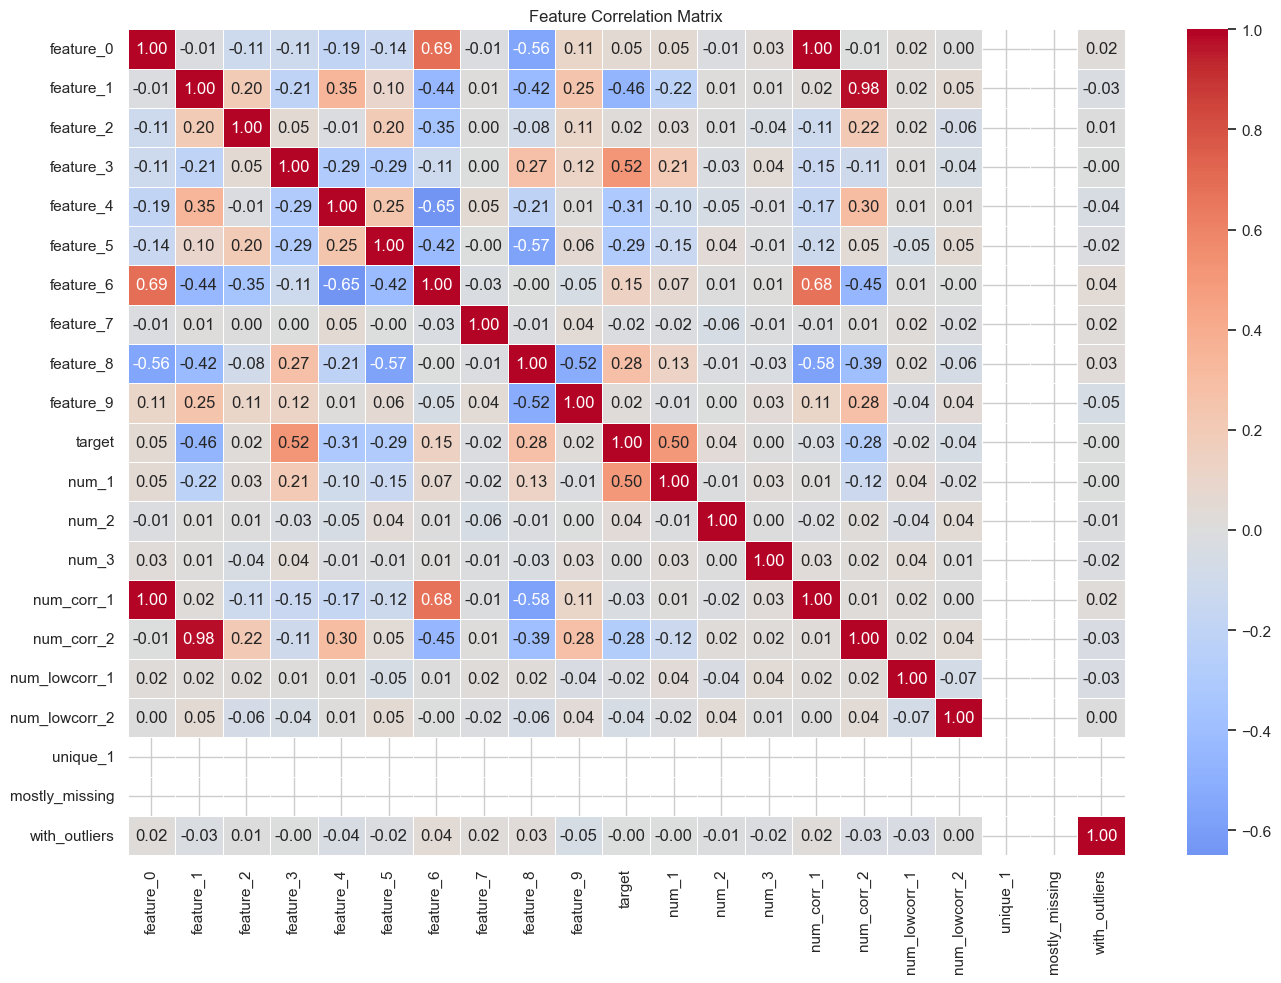


Highly correlated features (>|0.6|): {'num_corr_1', 'feature_6', 'num_corr_2'}

Data shape after removing correlated features: (1000, 21)


In [6]:
# Correlation analysis and visualization
# Select numerical features only
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
corr_matrix = df[num_cols].corr()

# Plot correlation heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', 
            center=0, linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=300)
plt.show()

# Identify highly correlated features (threshold = 0.6)
threshold = 0.6
high_corr = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            colname = corr_matrix.columns[i]
            high_corr.add(colname)

print(f"\nHighly correlated features (>|{threshold}|): {high_corr}")

# Remove highly correlated features
df_filtered = df.drop(columns=high_corr)
print(f"\nData shape after removing correlated features: {df_filtered.shape}")


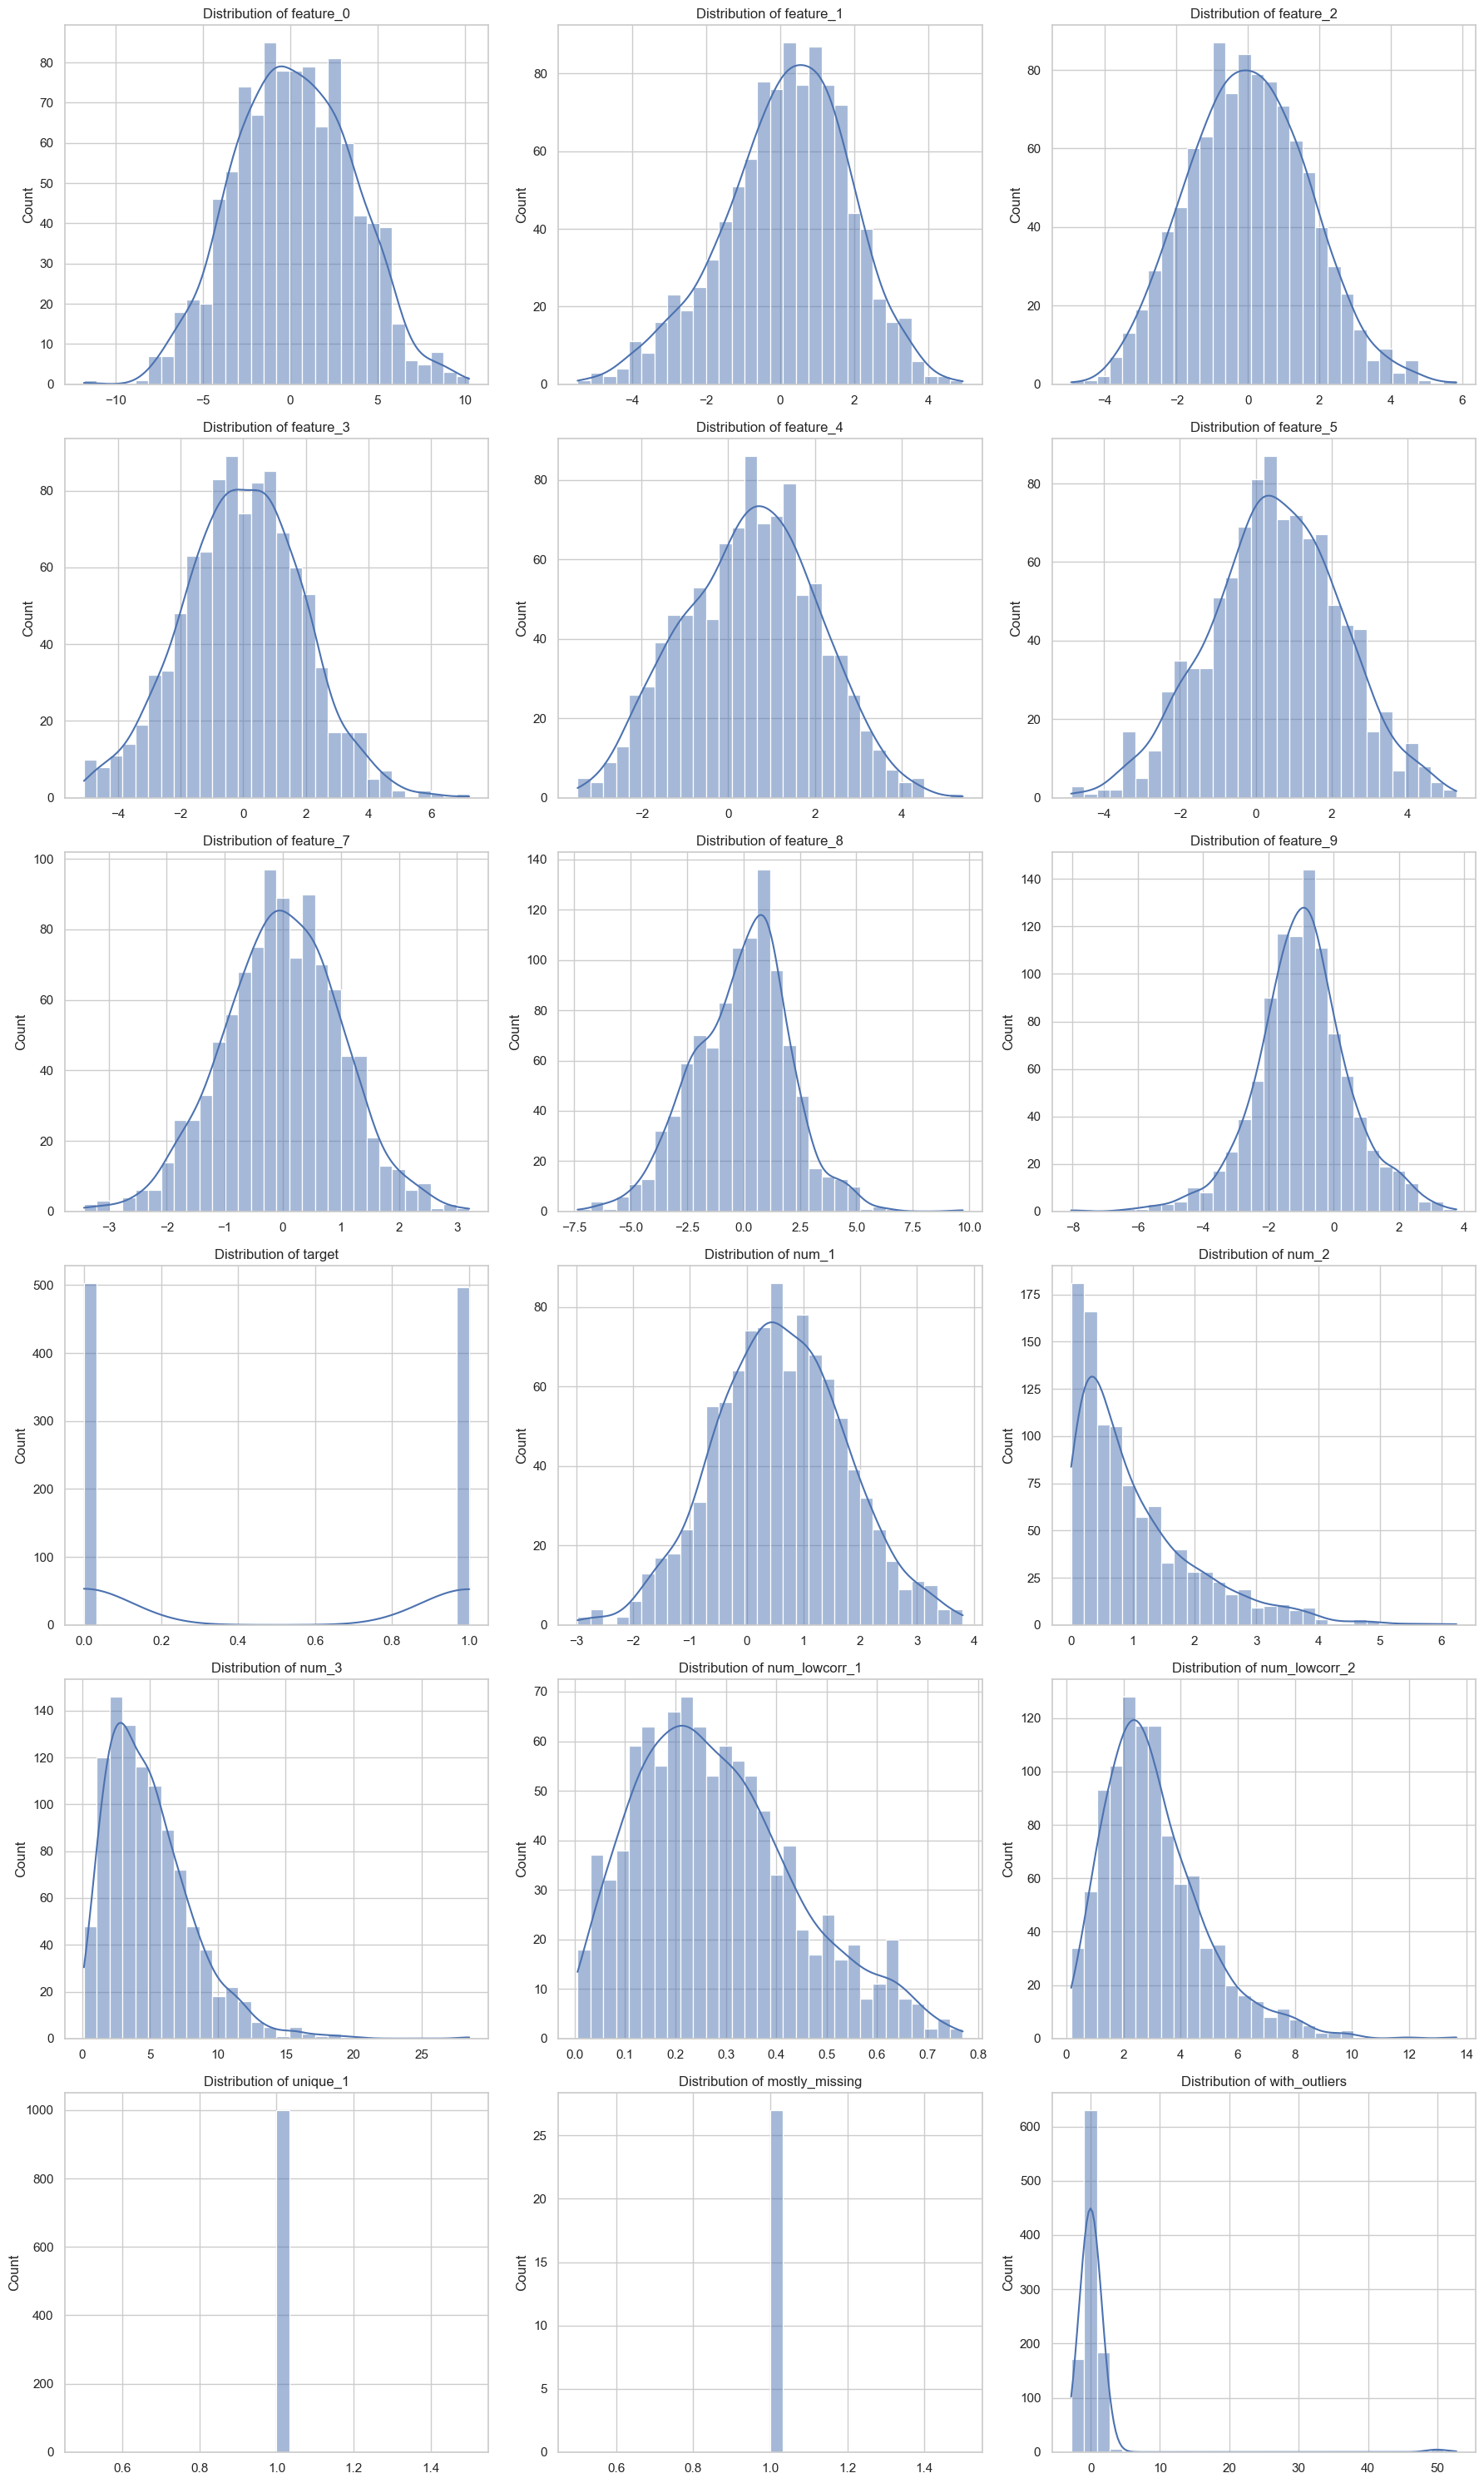

In [7]:
# Exploratory Data Analysis (EDA)
# 1. Distribution of numerical features
num_cols_filtered = df_filtered.select_dtypes(include=['float64', 'int64']).columns
n_cols = 3
n_rows = int(np.ceil(len(num_cols_filtered) / n_cols))

plt.figure(figsize=(18, 5 * n_rows))
for i, col in enumerate(num_cols_filtered):
    plt.subplot(n_rows, n_cols, i+1)
    sns.histplot(df_filtered[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel('')
plt.tight_layout()
plt.savefig('numerical_distributions.png', dpi=300)
plt.show()

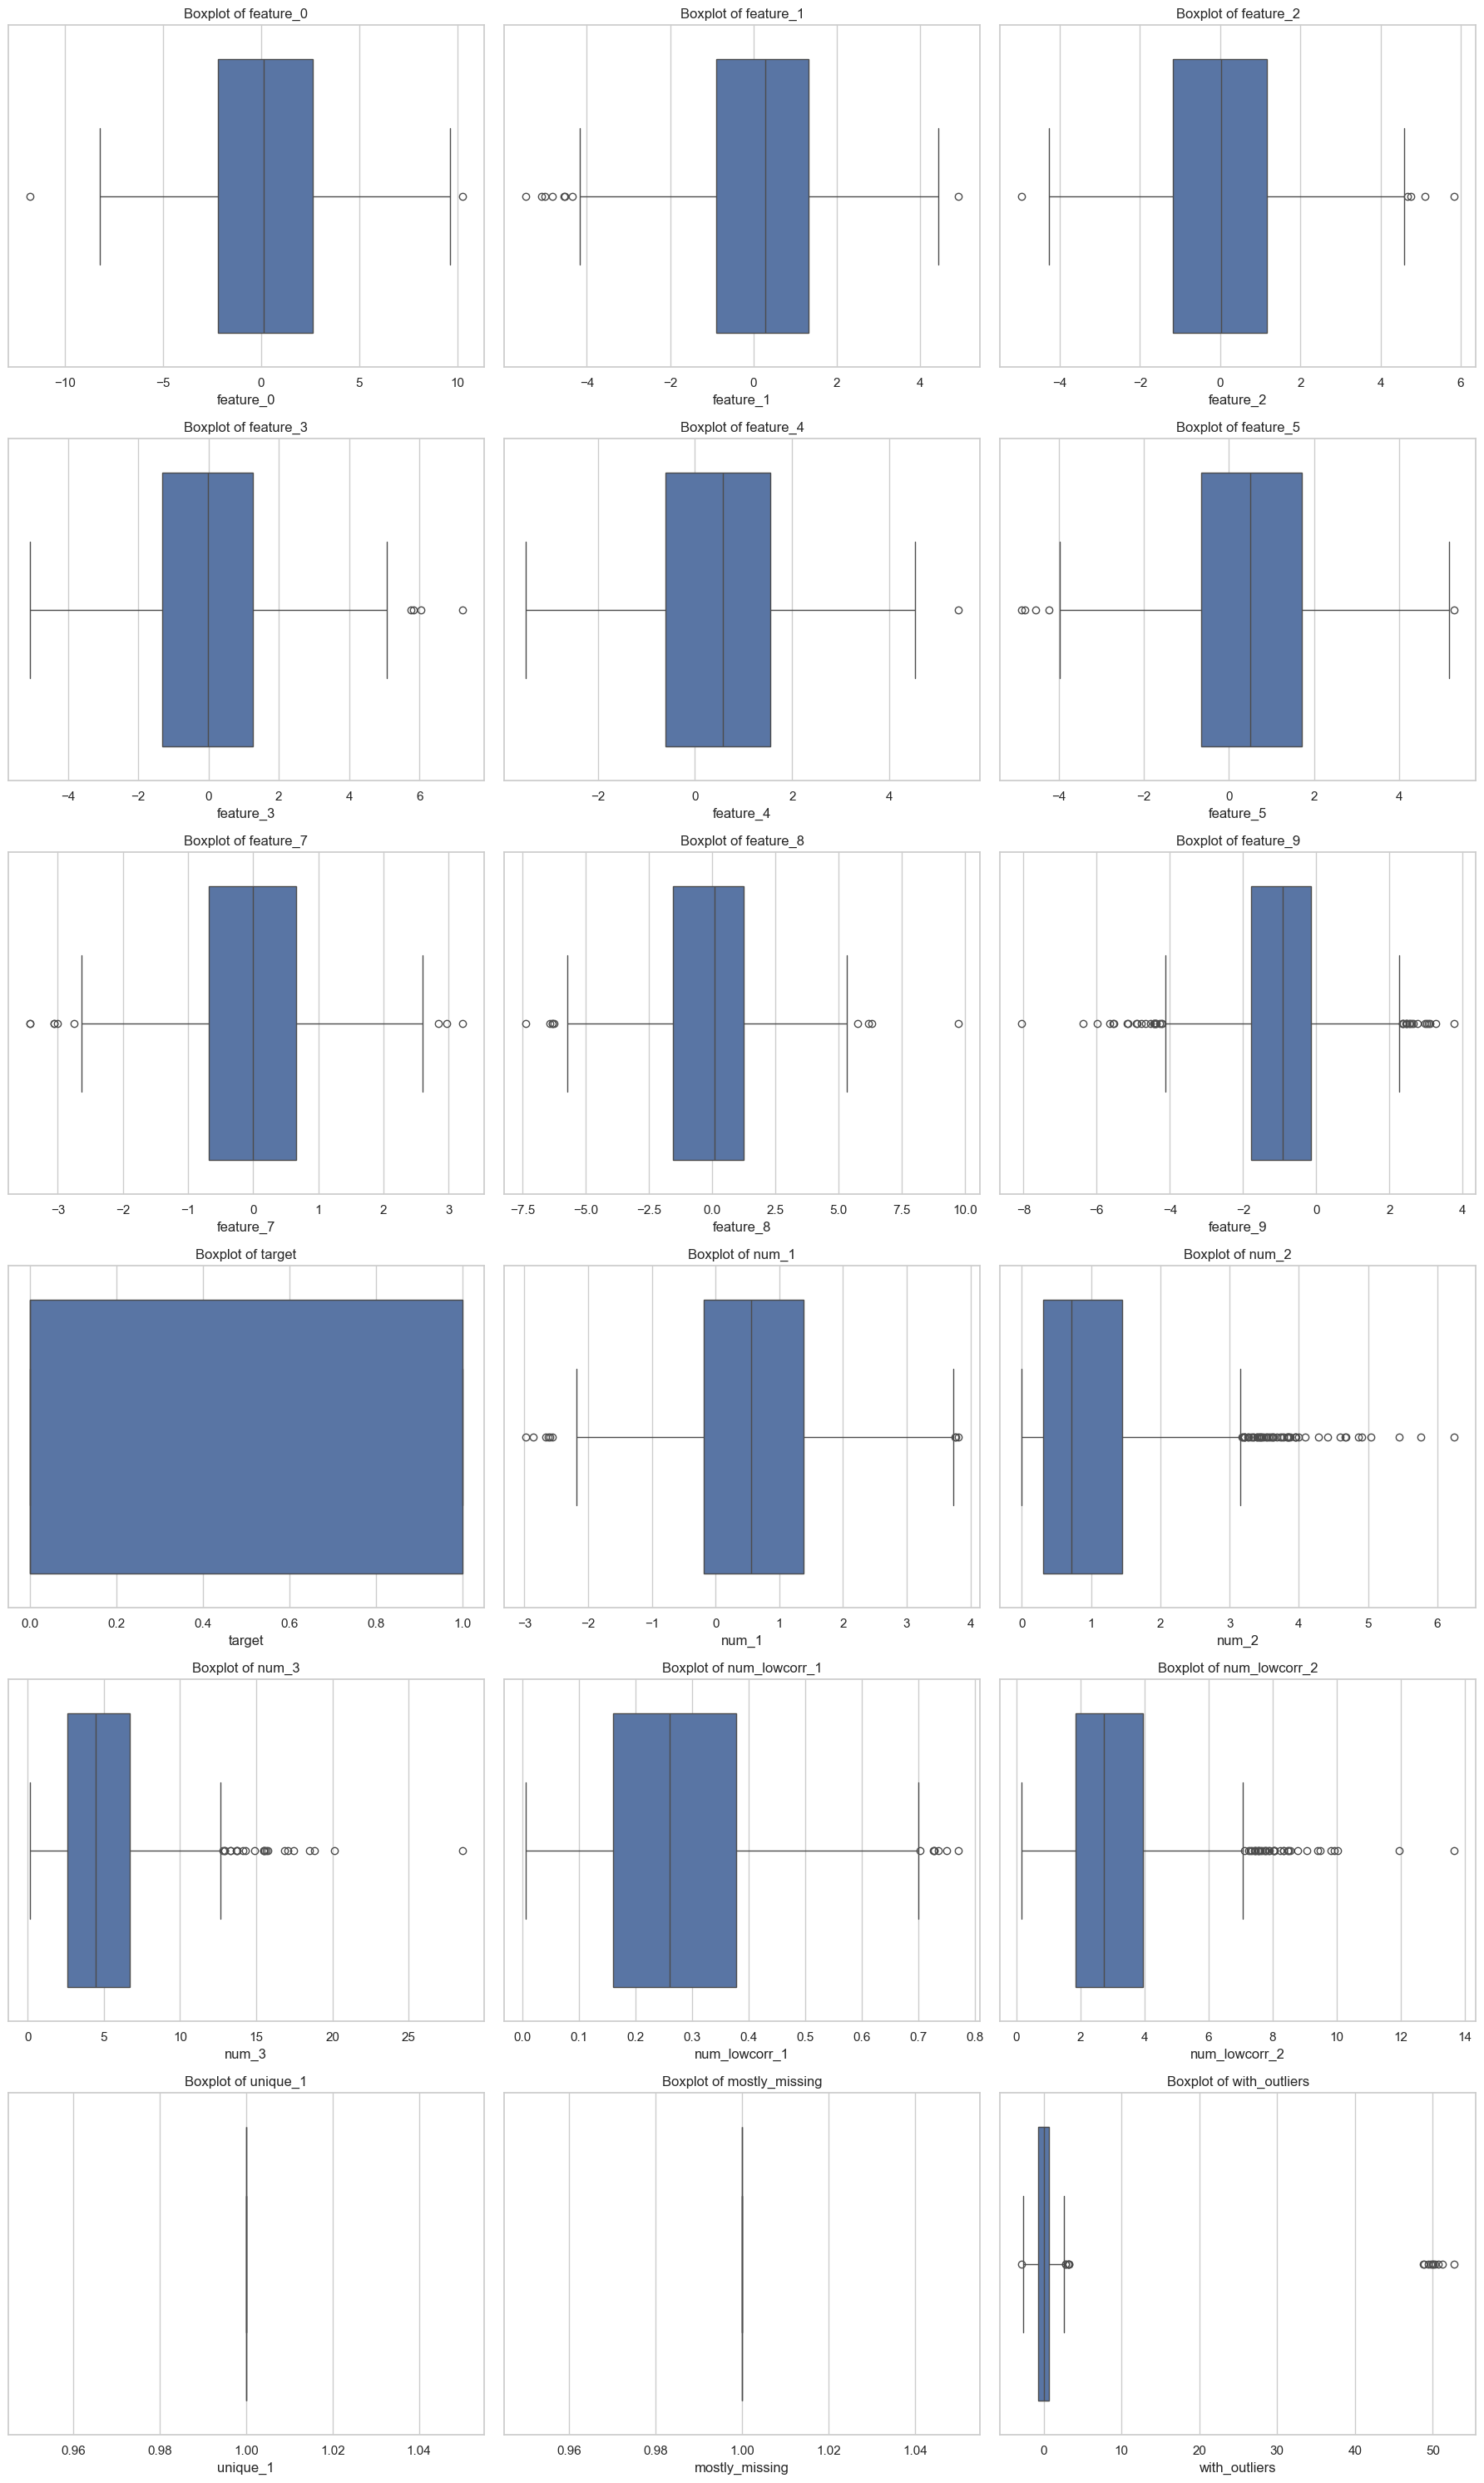

In [8]:
# 2: Boxplots for outlier detection
plt.figure(figsize=(18, 5 * n_rows))
for i, col in enumerate(num_cols_filtered):
    plt.subplot(n_rows, n_cols, i+1)
    sns.boxplot(x=df_filtered[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.savefig('outlier_detection.png', dpi=300)
plt.show()

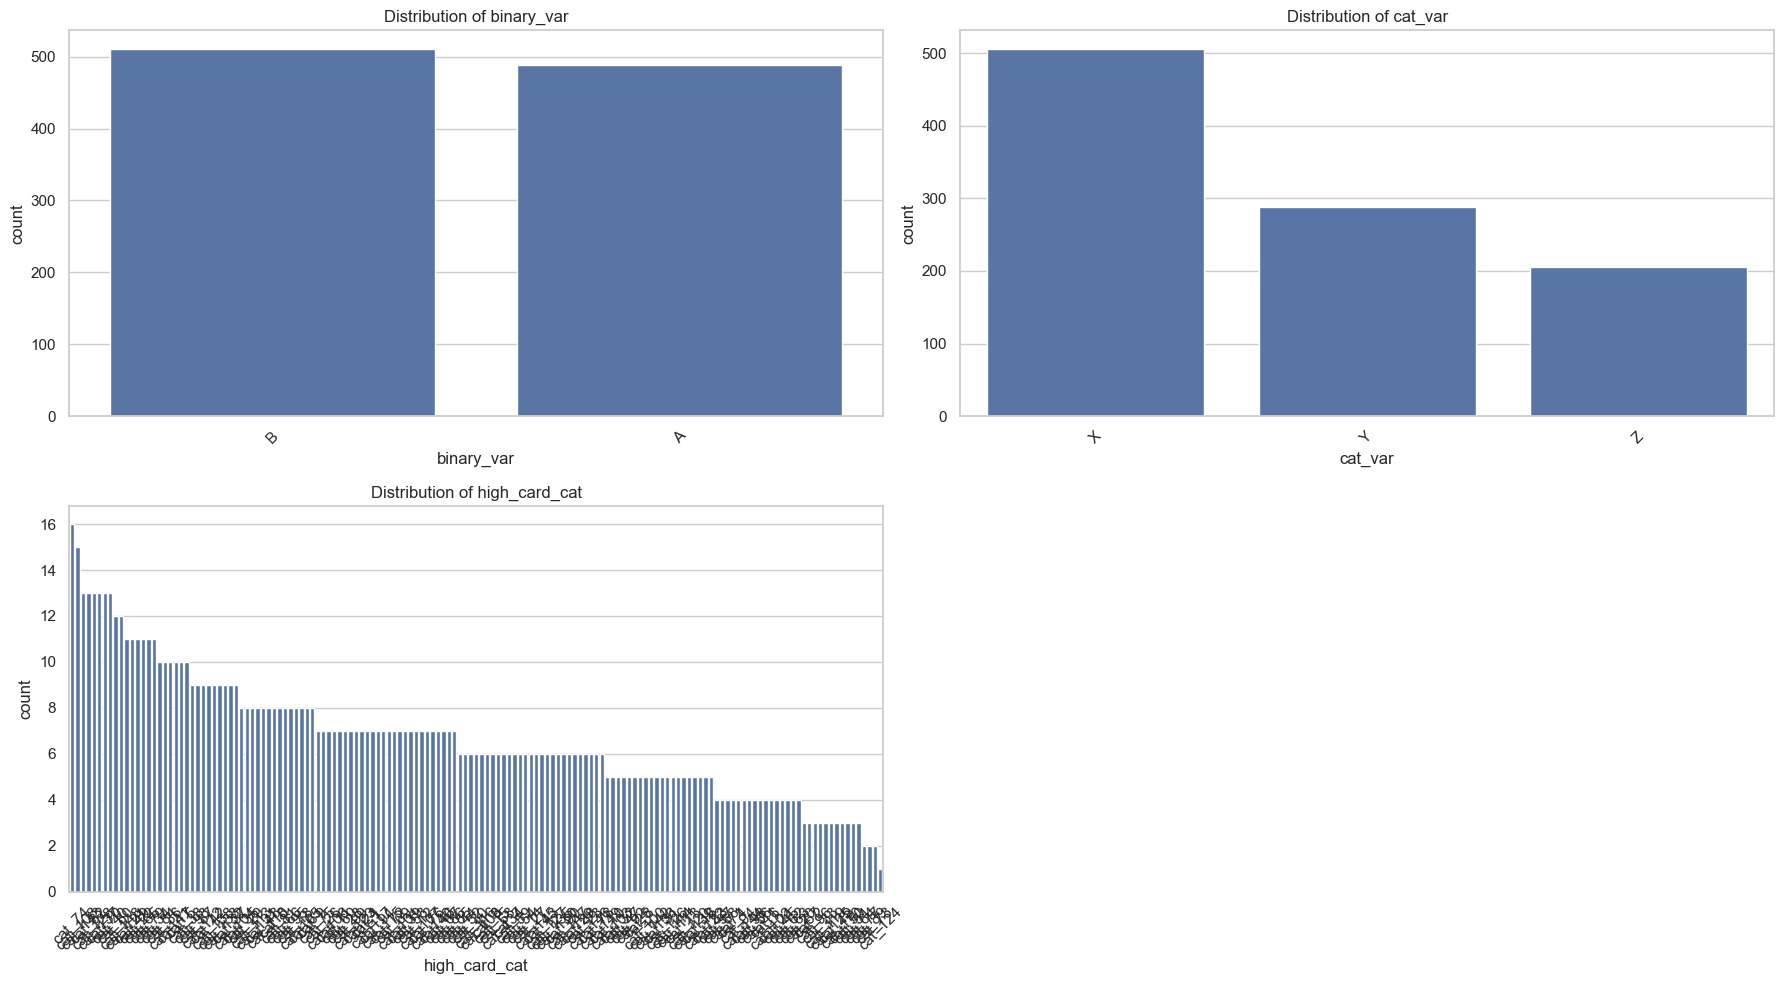

In [9]:
# 3: Categorical feature distributions
cat_cols = df_filtered.select_dtypes(include=['object', 'category']).columns
if len(cat_cols) > 0:
    n_rows = int(np.ceil(len(cat_cols) / 2))
    plt.figure(figsize=(18, 5 * n_rows))
    for i, col in enumerate(cat_cols):
        plt.subplot(n_rows, 2, i+1)
        order = df_filtered[col].value_counts().index
        sns.countplot(x=col, data=df_filtered, order=order)
        plt.title(f'Distribution of {col}')
        plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('categorical_distributions.png', dpi=300)
    plt.show()

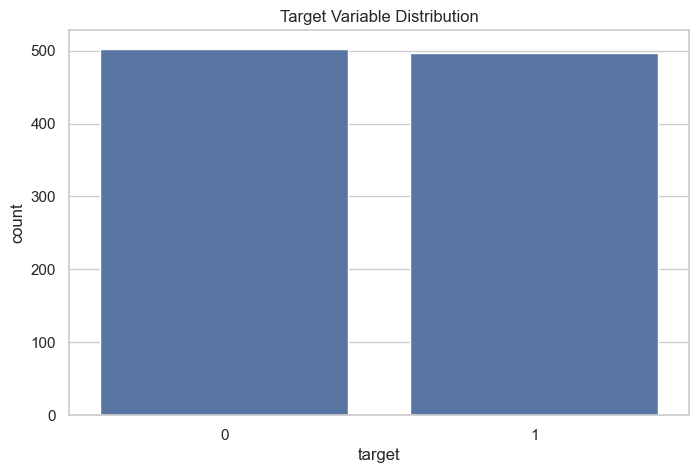

In [10]:
# 4: Target variable distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='target', data=df_filtered)
plt.title('Target Variable Distribution')
plt.savefig('target_distribution.png', dpi=300)
plt.show()

In [12]:
# Filter columns based on uniqueness and missingness
def filter_columns(df, target='target'):
    """Filter columns based on uniqueness and missingness criteria"""
    cols_to_remove = []
    
    for col in df.columns:
        # Skip target column
        if col == target:
            continue
            
        # Check missingness for ALL columns
        missing_pct = df[col].isnull().mean() * 100
        if missing_pct > 95:
            print(f"Removing '{col}' (high missingness: {missing_pct:.2f}% missing)")
            cols_to_remove.append(col)
            continue
            
        # Check uniqueness only for categorical columns
        if pd.api.types.is_categorical_dtype(df[col]) or \
           pd.api.types.is_object_dtype(df[col]) or \
           pd.api.types.is_string_dtype(df[col]) or \
           pd.api.types.is_bool_dtype(df[col]):
            
            unique_count = df[col].nunique()
            
            if unique_count == 1:
                print(f"Removing '{col}' (constant categorical feature)")
                cols_to_remove.append(col)
                continue
                
            if unique_count > 100:
                print(f"Removing '{col}' (high cardinality: {unique_count} unique values)")
                cols_to_remove.append(col)
                continue
    
    return df.drop(columns=cols_to_remove)

df_processed = filter_columns(df_filtered)
print(f"\nData shape after filtering: {df_processed.shape}")

# Update summary table
summary_processed = create_summary_table(df_processed)
print("\nProcessed Data Summary:")
display(summary_processed)

Removing 'high_card_cat' (high cardinality: 149 unique values)
Removing 'mostly_missing' (high missingness: 97.30% missing)

Data shape after filtering: (1000, 19)

Processed Data Summary:


,dtype,unique,unique_%,missing,missing_%
feature_0,float64,1000,100.0,0,0.0
num_1,float64,1000,100.0,0,0.0
unique_1,int64,1,0.1,0,0.0
cat_var,object,3,0.3,0,0.0
binary_var,object,2,0.2,0,0.0
num_lowcorr_2,float64,1000,100.0,0,0.0
num_lowcorr_1,float64,1000,100.0,0,0.0
num_3,float64,1000,100.0,0,0.0
num_2,float64,1000,100.0,0,0.0
target,int64,2,0.2,0,0.0


In [13]:
# Prepare data for modeling
# Separate features and target
X = df_processed.drop(columns=['target'])
y = df_processed['target']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)


In [14]:
# Identify feature types
num_features = X_train.select_dtypes(include=['float64', 'int64']).columns
cat_features = X_train.select_dtypes(include=['object', 'category']).columns


In [15]:
# Create preprocessing pipelines
num_pipeline = Pipeline([
    ('imputer', IterativeImputer(max_iter=10, random_state=42)),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

In [16]:
# LASSO Feature Selection
# Preprocess training data
X_train_processed = preprocessor.fit_transform(X_train)

# Fit LASSO for feature selection
lasso = LassoCV(cv=5, random_state=42, max_iter=10000)
lasso.fit(X_train_processed, y_train)

# Select features with non-zero coefficients
selector = SelectFromModel(lasso, prefit=True, threshold=1e-5)
X_train_selected = selector.transform(X_train_processed)

# Get selected feature names
feature_names = (list(num_features) + 
                 list(preprocessor.named_transformers_['cat']
                     .named_steps['encoder']
                     .get_feature_names_out(cat_features)))
selected_features = [feature_names[i] for i in selector.get_support(indices=True)]

print(f"Original features: {X_train_processed.shape[1]}")
print(f"Selected features: {len(selected_features)}")
print("\nSelected features:")
print(selected_features)

Original features: 21
Selected features: 18

Selected features:
['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_7', 'feature_8', 'feature_9', 'num_1', 'num_2', 'num_3', 'num_lowcorr_1', 'num_lowcorr_2', 'with_outliers', 'binary_var_A', 'cat_var_Y', 'cat_var_Z']


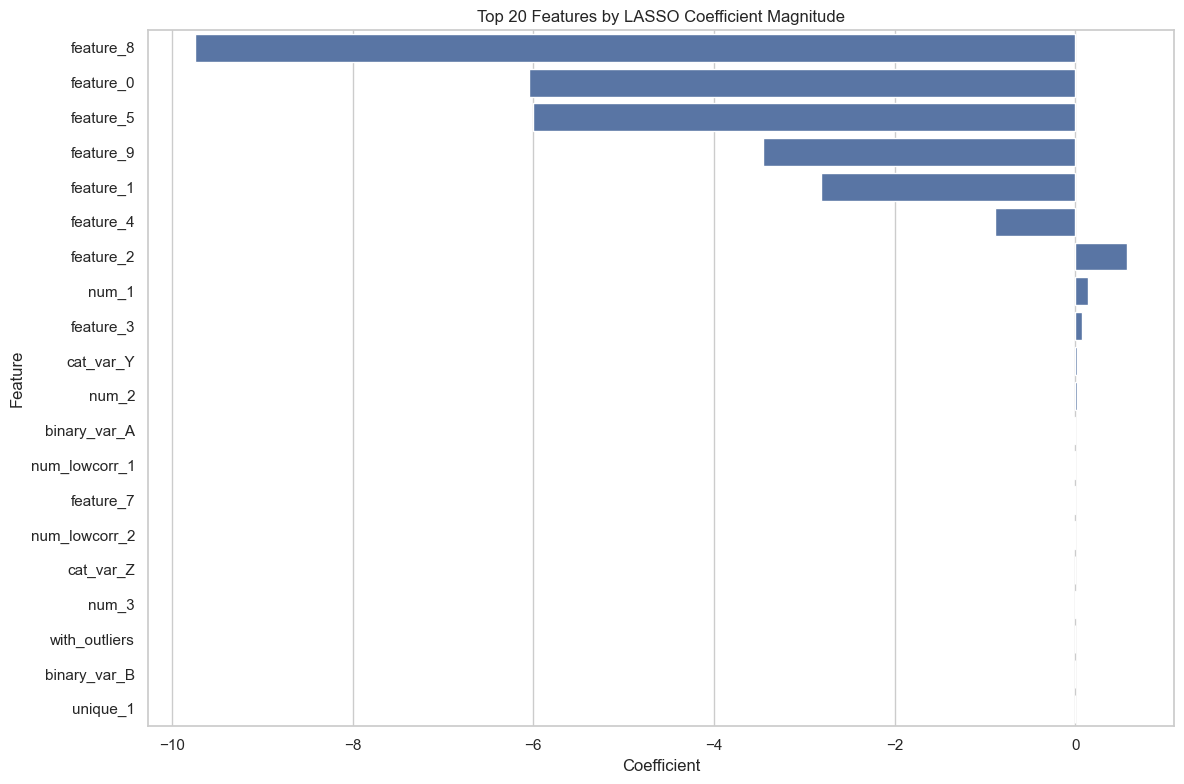

In [17]:
# Plot feature importance
plt.figure(figsize=(12, 8))
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': lasso.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

# Only show top 20 features
sns.barplot(x='Coefficient', y='Feature', 
            data=coef_df.head(20))
plt.title('Top 20 Features by LASSO Coefficient Magnitude')
plt.tight_layout()
plt.savefig('lasso_feature_importance.png', dpi=300)
plt.show()

# Build Regularized Model
# Create preprocessing + modeling pipeline
model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('selector', selector),
    ('classifier', LogisticRegression(
        penalty='l2', 
        C=0.1, 
        solver='liblinear',
        class_weight='balanced',
        random_state=42,
        max_iter=1000
    ))
])

In [18]:
# Fit the model
model_pipeline.fit(X_train, y_train)

# Evaluate on training set
y_train_pred = model_pipeline.predict(X_train)
y_train_prob = model_pipeline.predict_proba(X_train)[:, 1]

print("Training Performance:")
print(f"Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
print(f"Precision: {precision_score(y_train, y_train_pred):.4f}")
print(f"Recall: {recall_score(y_train, y_train_pred):.4f}")
print(f"F1 Score: {f1_score(y_train, y_train_pred):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_train, y_train_prob):.4f}")

Training Performance:
Accuracy: 0.8957
Precision: 0.9129
Recall: 0.8736
F1 Score: 0.8928
AUC-ROC: 0.9564


In [19]:
# Model Evaluation on Test Set
# Predict on test set
y_test_pred = model_pipeline.predict(X_test)
y_test_prob = model_pipeline.predict_proba(X_test)[:, 1]

# Calculate metrics
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
roc_auc = roc_auc_score(y_test, y_test_prob)

print("\nTest Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")


Test Performance:
Accuracy: 0.8533
Precision: 0.9008
Recall: 0.7919
F1 Score: 0.8429
AUC-ROC: 0.9309


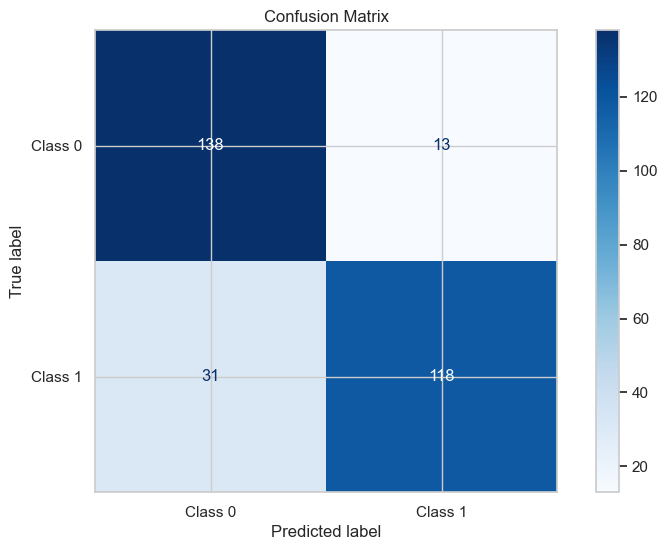

In [20]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=['Class 0', 'Class 1'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png', dpi=300)
plt.show()


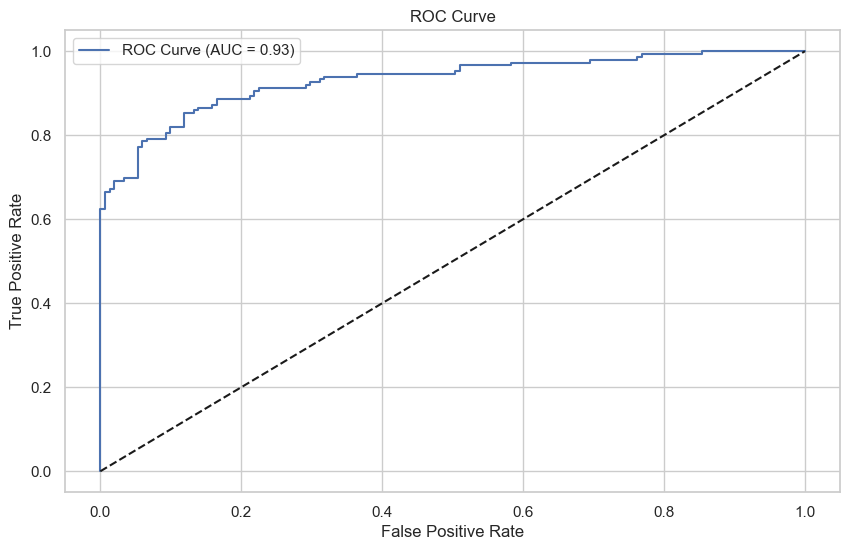

In [21]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_test_prob)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.savefig('roc_curve.png', dpi=300)
plt.show()

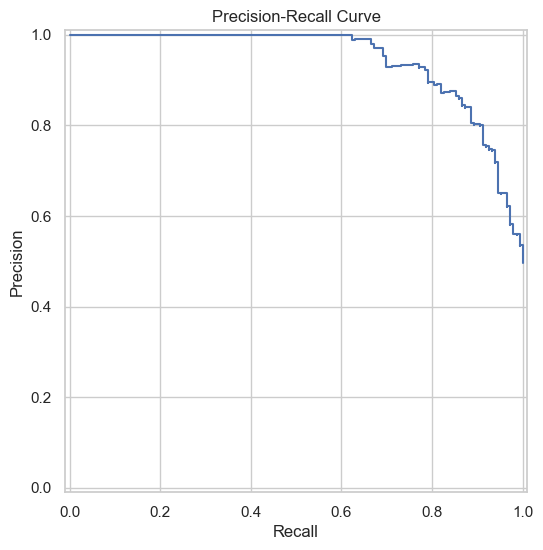

In [22]:
# Plot Precision-Recall curve
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_test_prob)
disp = PrecisionRecallDisplay(precision=precision_curve, recall=recall_curve)
disp.plot()
plt.title('Precision-Recall Curve')
plt.savefig('precision_recall_curve.png', dpi=300)
plt.show()

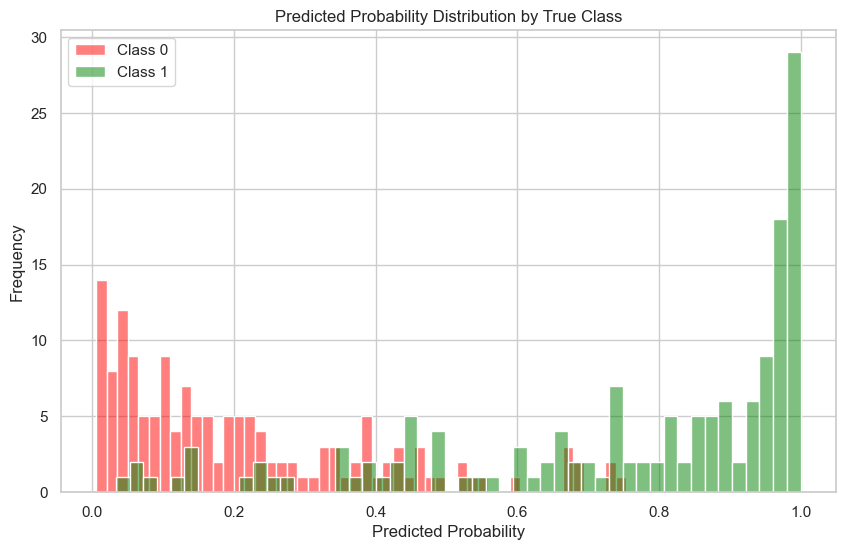

In [23]:
# Plot probability distributions
plt.figure(figsize=(10, 6))
sns.histplot(y_test_prob[y_test == 0], bins=50, color='red', alpha=0.5, label='Class 0')
sns.histplot(y_test_prob[y_test == 1], bins=50, color='green', alpha=0.5, label='Class 1')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Predicted Probability Distribution by True Class')
plt.legend()
plt.savefig('probability_distribution.png', dpi=300)
plt.show()